# Creating vector representations of SEU Neuron Morphologies

In [6]:
import getpass
import jwt
import pickle
import sys

import numpy as np
import pandas as pd

from kgforge.core import KnowledgeGraphForge
from kgforge.specializations.resources import Dataset

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from gensim.models.poincare import PoincareModel

from bluegraph import PandasPGFrame
from bluegraph.preprocess import ScikitLearnPGEncoder
from bluegraph.downstream.utils import transform_to_2d, plot_2d
from bluegraph.preprocess import CooccurrenceGenerator
from bluegraph.backends.stellargraph import StellarGraphNodeEmbedder
from bluegraph.backends.networkx import NXCommunityDetector
from bluegraph.downstream import EmbeddingPipeline
from bluegraph.downstream.similarity import SimilarityProcessor
from bluegraph import version as bg_version

In [7]:
def get_encoder_features(prop_name, encoder, last_index):
    if encoder is None or isinstance(encoder, StandardScaler):
        return {last_index: f"{prop_name}_IDENTITY"}, last_index + 1
    if isinstance(encoder, TfidfVectorizer):
        return (
            {
                i + last_index: f"{prop_name}_WORD_{f}"
                for i, f in enumerate(encoder.get_feature_names())
            },
            last_index + len(encoder.get_feature_names())
        )
    elif isinstance(encoder, MultiLabelBinarizer):
        return (
            {
                i + last_index: f"{prop_name}_CLASS_{c}"
                for i, c in enumerate(encoder.classes_)
            },
            last_index + len(encoder.classes_)
        )
    
    else:
        return {}, last_index

def explain_property_coordinates(encoder, graph):
    last_index = 0
    property_coordinates = {}
    for p in graph.node_properties():
        if p in encoder._node_encoders:
            res, new_index = get_encoder_features(
                p, encoder._node_encoders[p], last_index)
            property_coordinates.update(res)
            last_index = new_index
    return property_coordinates

## Load morphologies from Nexus

In [9]:
TOKEN = getpass.getpass()

········


In [10]:
forge = KnowledgeGraphForge("configs/new-forge-config.yaml",
                            token=TOKEN,
                            bucket="bbp-external/seu")

In [11]:
morphologies = forge.search({"type": "NeuronMorphology"}, limit=200, debug=True)

Submitted query:
   PREFIX bmc: <https://bbp.epfl.ch/ontologies/core/bmc/>
   PREFIX bmo: <https://bbp.epfl.ch/ontologies/core/bmo/>
   PREFIX commonshapes: <https://neuroshapes.org/commons/>
   PREFIX datashapes: <https://neuroshapes.org/dash/>
   PREFIX dc: <http://purl.org/dc/elements/1.1/>
   PREFIX dcat: <http://www.w3.org/ns/dcat#>
   PREFIX dcterms: <http://purl.org/dc/terms/>
   PREFIX mba: <http://api.brain-map.org/api/v2/data/Structure/>
   PREFIX nsg: <https://neuroshapes.org/>
   PREFIX nxv: <https://bluebrain.github.io/nexus/vocabulary/>
   PREFIX oa: <http://www.w3.org/ns/oa#>
   PREFIX owl: <http://www.w3.org/2002/07/owl#>
   PREFIX prov: <http://www.w3.org/ns/prov#>
   PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
   PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
   PREFIX schema: <http://schema.org/>
   PREFIX sh: <http://www.w3.org/ns/shacl#>
   PREFIX shsh: <http://www.w3.org/ns/shacl-shacl#>
   PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
  

In [27]:
morphologies_df = forge.as_dataframe(morphologies)[[
    "id",
    "brainLocation.brainRegion.id",
    "brainLocation.coordinatesInBrainAtlas.valueX.value",
    "brainLocation.coordinatesInBrainAtlas.valueY.value",
    "brainLocation.coordinatesInBrainAtlas.valueZ.value",
    "somaNumberOfPoints.value",
    "neuriteFeature",
    "subject.name",
    # to remove
    "atlasRelease.id",
    "objectOfStudy.label",
    "generation.activity.hadProtocol.id"
]]

<action> as_json
<error> TypeError: 'NoneType' object is not iterable



TypeError: 'NoneType' object is not subscriptable

In [22]:
forge = KnowledgeGraphForge(
    "configs/new-forge-config.yaml",
    token=TOKEN,
    bucket="neurosciencegraph/datamodels")

In [36]:
brain_region_resources = [
    forge.retrieve(el) for el in morphologies_df["brainLocation.brainRegion.id"]
]

In [37]:
brain_region_notation = {
    r.id: (r.notation, r.prefLabel)
    for r in brain_region_resources
}

In [38]:
with open("data/thalamus_partition_edges.pkl", "rb") as f:
    thalamus_partition = pickle.load(f)

In [61]:
# Mapping of Allen notations to uberon terms
allen_to_uberon = {
    "AM": "anteromedial nucleus of thalamus",
    'VPL': "ventral posterolateral nucleus",
    'SMT': "submedial nucleus of thalamus",
    'VAL': "ventral lateral nucleus of thalamus",
    'MG': "medial geniculate body",
    'PO': "posterior nuclear complex of thalamus",
    'CM': "central medial nucleus",
    'LP': "lateral posterior nucleus of thalamus",
    'VPMpc': "parvicellular part of ventral posteromedial nucleus",
    'VPM': "ventral posteromedial nucleus of thalamus",
    'RE': "reuniens nucleus",
    'MD': "medial dorsal nucleus of thalamus",
    'RT': "thalamic reticular nucleus",
    'VPLpc': "parvicellular part of ventral posteromedial nucleus",
    'LGd': "dorsal lateral geniculate nucleus",
    'IAD': "interanterodorsal nucleus of the thalamus",
    'PVT': "paraventricular nucleus of thalamus"
}

In [40]:
def get_notation(region_id):
    if region_id not in brain_region_notation:
        r = forge.retrieve(region_id)
        brain_region_notation[r.id] = (r.notation, r.prefLabel)
    return brain_region_notation[region_id][0]

In [41]:
def get_neurite_features(data):
    
    result = {
        "has_Axon_feature": 0,
        "has_BasalDendrite_feature": 0,
        "has_ApicalDendrite_feature": 0
    }
    
    def _process_data(el, prefix):
        result[f"{prefix}_cumulatedLength"] = el["cumulatedLength"]["value"]
        result[f"{prefix}_longestBranchLength"] = el["longestBranchLength"]["value"]
        result[f"{prefix}_longestBranchNumberOfNodes"] = el["longestBranchNumberOfNodes"]
        result[f"{prefix}_numberOfProjections"] = el["numberOfProjections"]
        result[f"{prefix}_projectionBrainRegion"] = {
            get_notation(r["id"]) for r in el["projectionBrainRegion"]
        } if isinstance(el["projectionBrainRegion"], list) else {get_notation(el["projectionBrainRegion"]["id"])}
        result[f"{prefix}_traversedBrainRegion"] = {
            get_notation(r["id"]) for r in el["traversedBrainRegion"]
        } if isinstance(el["traversedBrainRegion"], list) else {get_notation(el["traversedBrainRegion"]["id"])}

    for el in data:
        result["has_" + el["type"] + "_feature"] = 1
        _process_data(el, el["type"])

    return result

In [42]:
neurite_features = morphologies_df["neuriteFeature"].apply(get_neurite_features).tolist()

In [43]:
neurite_feature_df = pd.DataFrame(neurite_features)

In [44]:
morphologies_df["brainLocation.brainRegion.id"] = morphologies_df["brainLocation.brainRegion.id"].apply(
    lambda x: brain_region_notation[x][0])

In [45]:
morphologies_df.head(5)

,id,brainLocation.brainRegion.id,brainLocation.coordinatesInBrainAtlas.valueX.value,brainLocation.coordinatesInBrainAtlas.valueY.value,brainLocation.coordinatesInBrainAtlas.valueZ.value,somaNumberOfPoints.value,neuriteFeature,subject.name,atlasRelease.id,objectOfStudy.label,generation.activity.hadProtocol.id
0,https://bbp.epfl.ch/neurosciencegraph/data/neu...,AM,6368.0,4632.0,5263.0,4,"[{'type': 'BasalDendrite', 'cumulatedLength': ...",NaN,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
1,https://bbp.epfl.ch/neurosciencegraph/data/neu...,LGd,7283.0,2852.0,3534.0,3,"[{'type': 'BasalDendrite', 'cumulatedLength': ...",NaN,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
2,https://bbp.epfl.ch/neurosciencegraph/data/neu...,LGd,7571.0,2933.0,3536.0,3,"[{'type': 'BasalDendrite', 'cumulatedLength': ...",NaN,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
3,https://bbp.epfl.ch/neurosciencegraph/data/neu...,LGd,7026.0,3690.0,3451.0,3,"[{'type': 'BasalDendrite', 'cumulatedLength': ...",NaN,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
4,https://bbp.epfl.ch/neurosciencegraph/data/neu...,LGd,7452.0,2884.0,3605.0,3,"[{'type': 'BasalDendrite', 'cumulatedLength': ...",NaN,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...


## Create a property graph without edges

In [46]:
nodes = pd.concat(
    [morphologies_df, neurite_feature_df], axis=1).drop(
        columns=["neuriteFeature"]).rename(columns={"id": "@id"}).set_index("@id")

In [47]:
frame = PandasPGFrame()
frame._nodes = nodes
categorical_props = [
    "brainLocation.brainRegion.id",
    "subject.name",
    "has_Axon_feature",
    "has_BasalDendrite_feature",
    "has_ApicalDendrite_feature",
    "BasalDendrite_projectionBrainRegion",
    "BasalDendrite_traversedBrainRegion",
    "ApicalDendrite_projectionBrainRegion",
    "ApicalDendrite_traversedBrainRegion",
    "Axon_projectionBrainRegion",
    "Axon_traversedBrainRegion",
]
for column in nodes.columns:
    if column != "@type":
        if column not in categorical_props:
            try:
                frame.node_prop_as_numeric(column)
            except ValueError:
                pass
        else:
            frame.node_prop_as_category(column)
frame.rename_node_properties({
    p: p.replace(".", "_")
    for p in frame.node_properties()
})

## Encode properties

In [52]:
encoder = ScikitLearnPGEncoder(
    node_properties=frame.node_properties(),
    missing_numeric="impute",
    imputation_strategy="mean",
    reduce_node_dims=True,
    n_node_components=32)

In [53]:
encoded_frame = encoder.fit_transform(frame)

Explained variance of data

In [ ]:
sum(encoder.node_reducer.explained_variance_ratio_)

Let's plot a 2D projection of what we have got

In [ ]:
X = np.array(encoded_frame._nodes["features"].tolist())
features_2d = transform_to_2d(X)

In [ ]:
plot_2d(
    frame, vectors=features_2d, label_prop="brainLocation_brainRegion_id",
    title="Colored by Brain Region")

## Create co-projection PGFrames 

### Axon co-projection graph

In [ ]:
gen = CooccurrenceGenerator(frame)
axon_edges = gen.generate_from_nodes(
    "Axon_projectionBrainRegion",
    compute_statistics=["frequency"])

In [ ]:
axon_edges = axon_edges[axon_edges["frequency"].values > 3]

In [ ]:
axon_edges.shape

In [ ]:
axon_coprojection_frame = PandasPGFrame.from_frames(
    nodes=encoded_frame._nodes, edges=axon_edges)
axon_coprojection_frame.edge_prop_as_numeric("frequency")

### Dendrite co-projection graph

In [ ]:
gen = CooccurrenceGenerator(frame)
dendrite_edges = gen.generate_from_nodes(
    "BasalDendrite_projectionBrainRegion",
    compute_statistics=["frequency"])

In [ ]:
dendrite_edges = dendrite_edges[dendrite_edges["frequency"].values > 1]

In [ ]:
dendrite_edges.shape

In [ ]:
dendrite_coprojection_frame = PandasPGFrame.from_frames(
    nodes=encoded_frame._nodes, edges=dendrite_edges)
dendrite_coprojection_frame.edge_prop_as_numeric("frequency")

## Embed nodes

### Axon co-projection embedding

In [ ]:
axon_D = 128

In [ ]:
axon_attri2vec_embedder = StellarGraphNodeEmbedder(
    "attri2vec", feature_vector_prop="features",
    length=5, number_of_walks=10,
    epochs=10, embedding_dimension=axon_D, edge_weight="frequency")
axon_embedding = axon_attri2vec_embedder.fit_model(axon_coprojection_frame)

In [ ]:
axon_coprojection_frame.add_node_properties(
    axon_embedding.rename(columns={"embedding": "attri2vec"}))

In [ ]:
embedding_2d = transform_to_2d(axon_coprojection_frame._nodes["attri2vec"].tolist())
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

### Dendrite co-projection embedding

In [ ]:
dendrite_D = 100

In [ ]:
dendrite_attri2vec_embedder = StellarGraphNodeEmbedder(
    "attri2vec", feature_vector_prop="features",
    length=6, number_of_walks=20,
    epochs=15, embedding_dimension=dendrite_D, edge_weight="frequency")
dendrite_embedding = dendrite_attri2vec_embedder.fit_model(dendrite_coprojection_frame)

In [ ]:
dendrite_coprojection_frame.add_node_properties(
    dendrite_embedding.rename(columns={"embedding": "attri2vec"}))

In [ ]:
embedding_2d = transform_to_2d(dendrite_coprojection_frame._nodes["attri2vec"].tolist())
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

In [ ]:
# with open ("meta.tsv", "w") as f:
#     f.write("id\tregion\n")
#     for el in dendrite_attri2vec_embedding["embedding"].index:
#         f.write("{}\t{}\n".format(el, frame._nodes.loc[el, "brainLocation_brainRegion_id"]))

In [ ]:
# with open ("vecs.tsv", "w") as f:
#     for el in dendrite_attri2vec_embedding["embedding"].tolist():
#         f.write("\t".join([str(v) for v in el]) + "\n")

## Create and save the embedding pipelines

### Axon co-projection pipeline

In [42]:
sim_processor = SimilarityProcessor(similarity="cosine", dimension=axon_D)
sim_processor.add(axon_embedding["embedding"].tolist(),
                  axon_embedding.index)
pipeline = EmbeddingPipeline(
    preprocessor=encoder,
    embedder=axon_attri2vec_embedder,
    similarity_processor=sim_processor)

In [43]:
pipeline.save("SEU_morph_axon_coproj_attri2vec_cosine", compress=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: SEU_morph_axon_coproj_attri2vec_euclidean/embedder/model/assets


### Dendrite co-projection pipeline

In [44]:
sim_processor = SimilarityProcessor(similarity="cosine", dimension=dendrite_D)
sim_processor.add(dendrite_embedding["embedding"].tolist(),
                  dendrite_embedding.index)
pipeline = EmbeddingPipeline(
    preprocessor=encoder,
    embedder=dendrite_attri2vec_embedder,
    similarity_processor=sim_processor)

In [45]:
pipeline.save("SEU_morph_dendrite_coproj_attri2vec_cosine", compress=True)

INFO:tensorflow:Assets written to: SEU_morph_dendrite_coproj_attri2vec_euclidean/embedder/model/assets


## Push the model into the model catalog

In [46]:
TOKEN = getpass.getpass()

········


In [79]:
forge = KnowledgeGraphForge(
    "configs/new-forge-config.yaml",
    endpoint="https://staging.nexus.ocp.bbp.epfl.ch/v1",
    token=TOKEN,
    bucket="dke/embedder_catalog")

In [50]:
def get_agent(token):
    agent_data = jwt.decode(token, verify=False)
    agent = forge.reshape(
        forge.from_json(agent_data), keep=[
            "name", "email", "sub", "preferred_username"])
    agent.id = agent.sub
    agent.type = "Person"
    return agent

In [51]:
def push_model(forge, agent, name, description, label, distribution, similarity, dimension):
    # Create a new model resource
    model_resource = Dataset(
        forge,
        name=name,
        description=description)
    model_resource.type = "EmbeddingModel"
    model_resource.prefLabel = label
    model_resource.similarity = similarity
    model_resource.vectorDimension = dimension

    # Add distrubution
    if distribution is not None:
        model_resource.add_distribution(
            distribution, content_type="application/octet-stream")

    # Add contribution
    model_resource.add_contribution(agent, versioned=False)
    role = forge.from_json({
        "hadRole": {
            "id": "http://purl.obolibrary.org/obo/CRO_0000064",
            "label": "software engineering role"
        }
    })
    model_resource.contribution.hadRole = role

    # Add software agent
    software_agent = {
        "type": "SoftwareAgent",
        "description": "Unifying Python framework for graph analytics and co-occurrence analysis.",
        "name": "BlueGraph",
        "softwareSourceCode": {
            "type": "SoftwareSourceCode",
            "codeRepository": "https://github.com/BlueBrain/BlueGraph",
            "programmingLanguage": "Python",
            "runtimePlatform": f"{sys.version_info.major}.{sys.version_info.minor}",
            "version": bg_version.__version__
        }
    }
    model_resource.wasAssociatedWith = software_agent
    
    forge.register(model_resource)

In [52]:
agent = get_agent(TOKEN)

In [91]:
axon_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Axon Co-Projection Embedding",
    "Node embedding model built on an axon co-projection graph extracted from the SEU neuron morphology dataset resources",
    "Axon projection",
    "data/SEU_morph_axon_coproj_attri2vec_euclidean.zip", "cosine",
    axon_D)

<action> _register_one
<succeeded> True


In [92]:
dendrite_model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Dendrite Co-Projection Embedding",
    "Node embedding model built on a dendrite co-projection graph extracted from the SEU neuron morphology dataset resources",
    "Dendrite projection",
    "SEU_morph_dendrite_coproj_attri2vec_euclidean.zip", "cosine",
    dendrite_D)

<action> _register_one
<succeeded> True


## Visualize the graph in Gephi

In [ ]:
frame.export_to_gephi(
    "seu_morphologies_co_proj",
    node_attr_mapping={
        "brainLocation_brainRegion_id": "Region"
    },
    edge_attr_mapping={
        "frequency": "weight"
    })

<img src="figures/neu_co_proj_illustration.png">

## Create a df with different representations (for testing pipelined recommendation/search)

### Create coordinate vectors

In [53]:
coordinate_df = pd.DataFrame(morphologies_df["id"])

In [54]:
coordinate_df["coordinates"] = pd.Series(morphologies_df[[
    "brainLocation.coordinatesInBrainAtlas.valueX.value",
    "brainLocation.coordinatesInBrainAtlas.valueY.value",
    "brainLocation.coordinatesInBrainAtlas.valueZ.value"
]].values.tolist()).apply(lambda x: [float(el) for el in x])
coordinate_df = coordinate_df.rename(columns={"id": "@id"})

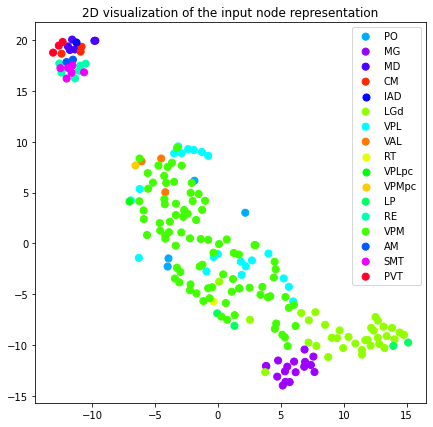

In [55]:
embedding_2d = transform_to_2d([[float(v) for v in el] for el in coordinate_df["coordinates"].tolist()])
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

### Create neurite feature vectors

In [56]:
feature_columns = [
#     'somaNumberOfPoints.value',
    'Axon_cumulatedLength',
    'Axon_longestBranchLength',
    'Axon_longestBranchNumberOfNodes',
    'Axon_numberOfProjections',
#     "Axon_traversedBrainRegion",
    'BasalDendrite_cumulatedLength',
    'BasalDendrite_longestBranchLength',
    'BasalDendrite_longestBranchNumberOfNodes',
    'BasalDendrite_numberOfProjections',
#     "BasalDendrite_traversedBrainRegion",
    'ApicalDendrite_cumulatedLength',
    'ApicalDendrite_longestBranchLength',
    'ApicalDendrite_longestBranchNumberOfNodes',
    'ApicalDendrite_numberOfProjections',
#     'ApicalDendrite_traversedBrainRegion'
]

In [57]:
neurite_features = nodes[[c for c in neurite_feature_df.columns if c in feature_columns]]

In [58]:
neurite_frame = PandasPGFrame.from_frames(
    nodes=neurite_features, edges=pd.DataFrame())

In [59]:
for c in neurite_frame._nodes.columns:
    try:
        neurite_frame.node_prop_as_numeric(c)
    except:
        neurite_frame.node_prop_as_category(c)

In [70]:
encoder = ScikitLearnPGEncoder(
    node_properties=neurite_frame.node_properties(),
    missing_numeric="impute",
    imputation_strategy="mean")
encoded_frame = encoder.fit_transform(neurite_frame)

In [86]:
neurite_features = encoded_frame._nodes.rename(columns={"features": "neurite_features"})

In [87]:
data = np.array(neurite_features["neurite_features"].tolist())
neurite_features["neurite_features"] = (data / data.max()).tolist()

In [88]:
neurite_dim = len(neurite_features["neurite_features"].iloc[0])

In [89]:
sim_processor = SimilarityProcessor(similarity="euclidean", dimension=neurite_dim)
sim_processor.add(neurite_features["neurite_features"],
                  neurite_features.index)
pipeline = EmbeddingPipeline(
    preprocessor=encoder,
    embedder=None,
    similarity_processor=sim_processor)
pipeline.save("SEU_morph_neurite_features_euclidean", compress=True)

In [75]:
model_resource = push_model(
    forge, agent, "SEU NeuronMorphology Neurite Features",
    "Feature encoding model built for neurite features from the SEU neuron morphology dataset resources",
    "Neurite features",
    "SEU_morph_neurite_features_euclidean.zip", "euclidean", neurite_dim)

<action> _register_one
<succeeded> True


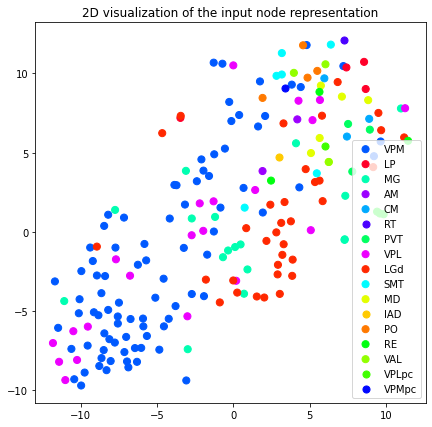

In [69]:
embedding_2d = transform_to_2d(encoded_frame._nodes["features"].tolist())
plot_2d(frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

### Ontology-based hierarchical brain region embedding

In [83]:
model = PoincareModel(thalamus_partition, size=32, negative=2)
model.train(epochs=100)

In [84]:
vectors = {
    allen_to_uberon[el]: model.kv.get_vector(allen_to_uberon[el])
    for el in morphologies_df["brainLocation.brainRegion.id"]
}

In [85]:
region_embedding_df = morphologies_df[["id", "brainLocation.brainRegion.id"]].copy()

In [86]:
region_embedding_df["uberon_term"] = region_embedding_df[
    "brainLocation.brainRegion.id"].apply(lambda x: allen_to_uberon[x])
region_embedding_df["region_vector"] = region_embedding_df[
    "uberon_term"].apply(lambda x: vectors[x])

In [89]:
region_embedding_df = region_embedding_df.drop(
    columns="brainLocation.brainRegion.id").rename(columns={"id": "@id"})

### Create co-projection graph representations

In [70]:
axon_proj_frame = PandasPGFrame.from_frames(
    nodes=frame._nodes[["brainLocation_brainRegion_id", "Axon_projectionBrainRegion"]], edges=pd.DataFrame())
dendrite_proj_frame = PandasPGFrame.from_frames(
    nodes=frame._nodes[["brainLocation_brainRegion_id", "BasalDendrite_projectionBrainRegion"]], edges=pd.DataFrame())

Create a co-projection graph based on axon projections (output)

In [71]:
gen = CooccurrenceGenerator(axon_proj_frame)
edges = gen.generate_from_nodes(
    "Axon_projectionBrainRegion",
    compute_statistics=["frequency"])
edges = edges[edges["frequency"].values > 3]
axon_proj_frame._edges = edges
axon_proj_frame.edge_prop_as_numeric("frequency")

In [72]:
watchyourstep_embedder = StellarGraphNodeEmbedder(
    "watchyourstep", directed=False, epochs=100, num_walks=80,
    embedding_dimension=128, num_powers=10)
watchyourstep_embedding = watchyourstep_embedder.fit_model(axon_proj_frame)

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/bluegraph/backends/stellargraph/embed/embedders.py:86: FittingWarning: StellarGraphNodeEmbedder's model 'watchyourstep' does not support the training parameter 'num_walks', the parameter will be ignored
  GraphElementEmbedder.FittingWarning)
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests (see: https://github.com/stellargraph/stellargraph/issues/804). It may be difficult to use and may have major changes at any time.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


In [73]:
axon_proj_frame.add_node_properties(
    watchyourstep_embedding.rename(columns={"embedding": "axon_coproj_embedding"}))

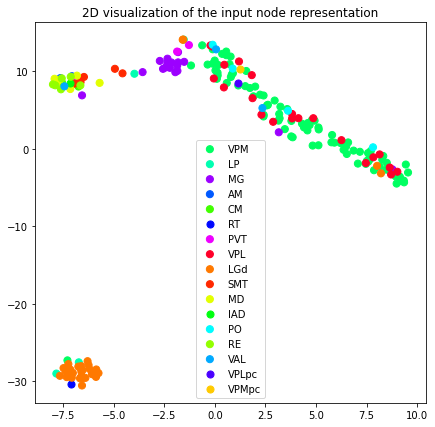

In [74]:
embedding_2d = transform_to_2d(axon_proj_frame._nodes["axon_coproj_embedding"].tolist())
plot_2d(axon_proj_frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

Create a co-projection graph based on dendrite projections (input)

In [75]:
gen = CooccurrenceGenerator(dendrite_proj_frame)
edges = gen.generate_from_nodes(
    "BasalDendrite_projectionBrainRegion",
    compute_statistics=["frequency"])
edges = edges[edges["frequency"].values > 3]
dendrite_proj_frame._edges = edges
dendrite_proj_frame.edge_prop_as_numeric("frequency")

In [76]:
watchyourstep_embedder = StellarGraphNodeEmbedder(
    "watchyourstep", directed=False, epochs=100, num_walks=80,
    embedding_dimension=128, num_powers=10)
watchyourstep_embedding = watchyourstep_embedder.fit_model(dendrite_proj_frame)

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/bluegraph/backends/stellargraph/embed/embedders.py:86: FittingWarning: StellarGraphNodeEmbedder's model 'watchyourstep' does not support the training parameter 'num_walks', the parameter will be ignored
  GraphElementEmbedder.FittingWarning)
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/stellargraph/core/utils.py:134: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests (see: https://github.com/stellargraph/stellargraph/issues/804). It may be difficult to use and may have major changes at any time.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


In [77]:
dendrite_proj_frame.add_node_properties(
    watchyourstep_embedding.rename(columns={"embedding": "dendrite_coproj_embedding"}))

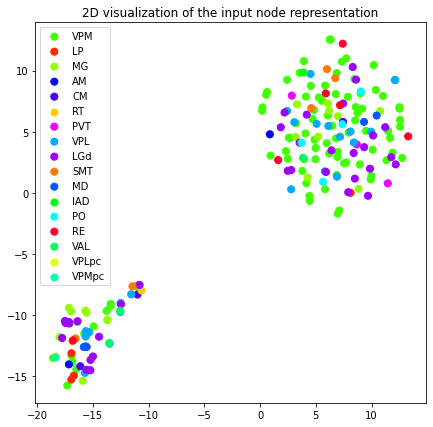

In [78]:
embedding_2d = transform_to_2d(dendrite_proj_frame._nodes["dendrite_coproj_embedding"].tolist())
plot_2d(dendrite_proj_frame, vectors=embedding_2d, label_prop="brainLocation_brainRegion_id")

In [90]:
combined_data = coordinate_df.merge(
    neurite_features.reset_index(), on="@id").merge(
        axon_proj_frame._nodes[["axon_coproj_embedding"]].reset_index(),
        on="@id").merge(
            dendrite_proj_frame._nodes[["dendrite_coproj_embedding"]].reset_index()).merge(
                morphologies_df[[
                    "id",
                    "brainLocation.brainRegion.id",
                    "atlasRelease.id",
                    "objectOfStudy.label",
                    "generation.activity.hadProtocol.id"]].rename(columns={"id": "@id"}),
                on="@id").merge(region_embedding_df, on="@id")

NameError: name 'coordinate_df' is not defined

In [80]:
combined_data["coordinates"] = combined_data["coordinates"].apply(lambda x: [float(el) for el in x])

In [82]:
combined_data = combined_data.rename(
    columns={
        "brainLocation.brainRegion.id": "brain_region",
        'atlasRelease.id': "atlas_release",
        "objectOfStudy.label": "object_of_study"
    })

In [83]:
combined_data.to_csv("data/combined_data.csv", index=None)